In [8]:
# !pip install scikeras
# !pip install python-bcb==0.3.3
# !pip install --upgrade scikit-learn

In [9]:
## 1. Importação de Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

import yfinance as yf
from bcb import sgs

In [10]:
## 2. Coleta dos Dados

# Datas de início e fim
start = '2016-01-01'
end = '2025-06-25'

# Dados da VALE3 (Close e Volume)
vale = yf.download('VALE3.SA', start=start, end=end)[['Close', 'Volume']]
vale.columns = ['Close_VALE3', 'Volume_VALE3']

# Dólar
dolar = sgs.get({'Close_Dolar': 1}, start=start, end=end).reset_index()
dolar['Date'] = pd.to_datetime(dolar['Date'])
dolar.set_index('Date', inplace=True)

# Petróleo (WTI) pelo Yahoo Finance
petroleo = yf.download('CL=F', start=start, end=end)[['Close']]
petroleo.columns = ['Close_Petroleo']

# Ibovespa
ibov = yf.download('^BVSP', start=start, end=end)[['Close']]
ibov.columns = ['Close_Ibovespa']

# Minério de Ferro (supondo índice internacional)
minerio = yf.download('PIO', start=start, end=end)[['Close']]
minerio.columns = ['Close_Minerio']

/tmp/ipython-input-10-4039765520.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vale = yf.download('VALE3.SA', start=start, end=end)[['Close', 'Volume']]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-4039765520.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  petroleo = yf.download('CL=F', start=start, end=end)[['Close']]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-4039765520.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ibov = yf.download('^BVSP', start=start, end=end)[['Close']]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-10-4039765520.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  minerio = yf.download('PIO', start=start, end=end)[['Close']]
[*********************100%***********************]  1

In [23]:
## 3. Preparação e Merge dos Dados

# Unificar tudo em um DataFrame
df = vale.copy()
df = df.merge(dolar, left_index=True, right_index=True, how='left')
df = df.merge(petroleo, left_index=True, right_index=True, how='left')
df = df.merge(ibov, left_index=True, right_index=True, how='left')
df = df.merge(minerio, left_index=True, right_index=True, how='left')

# Remover valores nulos
df.dropna(inplace=True)
df.tail()

,Close_VALE3,Volume_VALE3,Close_Dolar,Close_Petroleo,Close_Ibovespa,Close_Minerio
Date,,,,,,
2025-06-17,51.410000,43657300,5.4773,74.839996,138840.0,43.037945
2025-06-18,51.240002,20499000,5.4879,75.139999,138717.0,42.879242
2025-06-20,49.919998,39947200,5.4957,74.930000,137116.0,42.908997
2025-06-23,50.549999,17288800,5.5213,68.510002,136551.0,43.340000
2025-06-24,50.540001,18576300,5.4938,64.370003,137165.0,43.790001


In [12]:
## 4. Normalização

scaler = MinMaxScaler()
dados_escalados = scaler.fit_transform(df)

In [22]:
## 5. Criação da Janela Deslizante (21 dias)

def createXY(dataset, n_past):
    dataX, dataY = [], []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, :])
        dataY.append(dataset[i, 0])  # Close_VALE3
    return np.array(dataX), np.array(dataY)

X, y = createXY(dados_escalados, 21)

# Separar treino e teste (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Separar treino e teste (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
len(y_test)

453

In [14]:
## 6. Construção do Modelo com GridSearchCV (2ª arquitetura)

def build_model(optimizer='adam'):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(21, X_train.shape[2])))
    model.add(LSTM(64))
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model


model = KerasRegressor(model=build_model, verbose=1)

params = {
    'batch_size': [20, 32],
    'epochs': [20],
    'optimizer': ['adam']
}

grid = GridSearchCV(estimator=model, param_grid=params, cv=3)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0766
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0016
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0013
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0012
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0011
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0011
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0010
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 9.2965e-04
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.5113e-04
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.3085e-04
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 7.6420e-04
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 8.7906e-04
Epoch 13/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 8.6868e-04
Epoch 14/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.2173e-04
Epoch 15/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0531
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0018
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0015
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 9.0855e-04
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0010
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0012
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 9.8549e-04
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 7.4707e-04
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 8.2863e-04
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 6.7923e-04
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 6.4252e-04
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.7583e-04
Epoch 13/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.6782e-04
Epoch 14/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 7.2569e-04
Epoch 15/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0081
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 6.0319e-04
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.2544e-04
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.5351e-04
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.9782e-04
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.7017e-04
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 3.6576e-04
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 4.3297e-04
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.6276e-04
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.9692e-04
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.0823e-04
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.6553e-04
Epoch 13/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 3.4816e-04
Epoch 14/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.1787e-04
Epoch 15/20
61/61 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0755
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0021
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0012
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0012
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0012
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0011
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0011
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 8.9244e-04
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0011
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0010
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 9.2723e-04
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 7.6407e-04
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 9.1058e-04
Epoch 14/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 9.2242e-04
Epoch 15/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 7.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0959
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0027
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0014
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0011
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0010
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0012
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0011
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 8.4147e-04
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 9.3639e-04
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0013
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 8.5709e-04
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 8.1528e-04
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 7.6858e-04
Epoch 14/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0010
Epoch 15/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 8.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0141
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 8.3470e-04
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 4.3716e-04
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 4.7323e-04
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 4.0060e-04
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 4.3902e-04
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 3.3636e-04
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 4.2657e-04
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.8734e-04
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.7754e-04
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.1596e-04
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 3.2419e-04
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 3.2629e-04
Epoch 14/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.5748e-04
Epoch 15/20
38/38 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0279
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0010
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0010
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 7.7749e-04
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 6.4875e-04
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 7.5526e-04
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 7.4902e-04
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 5.3981e-04
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0013
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 6.1812e-04
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.8580e-04
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 5.1455e-04
Epoch 13/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.8081e-04
Epoch 14/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.8092e-04
Epoch 15/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [18]:
## 7. Avaliação do Modelo

best_model = grid_result.best_estimator_
pred = best_model.predict(X_test)

# Expande as previsões para 6 colunas simuladas (como se fossem as 6 features)
pred_expand = np.repeat(pred.reshape(-1, 1), df.shape[1], axis=1)
y_expand = np.repeat(y_test.reshape(-1, 1), df.shape[1], axis=1)

# Inverte a normalização e pega só a primeira coluna (Close_VALE3)
pred_real = scaler.inverse_transform(pred_expand)[:, 0]
y_real = scaler.inverse_transform(y_expand)[:, 0]

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [19]:
# Métricas
print("MAE:", mean_absolute_error(y_real, pred_real))
print("MAPE:", mean_absolute_percentage_error(y_real, pred_real))
print("R²:", r2_score(y_real, pred_real))

MAE: 0.9650797812354484
MAPE: 0.017127452544198805
R²: 0.8905114829265488


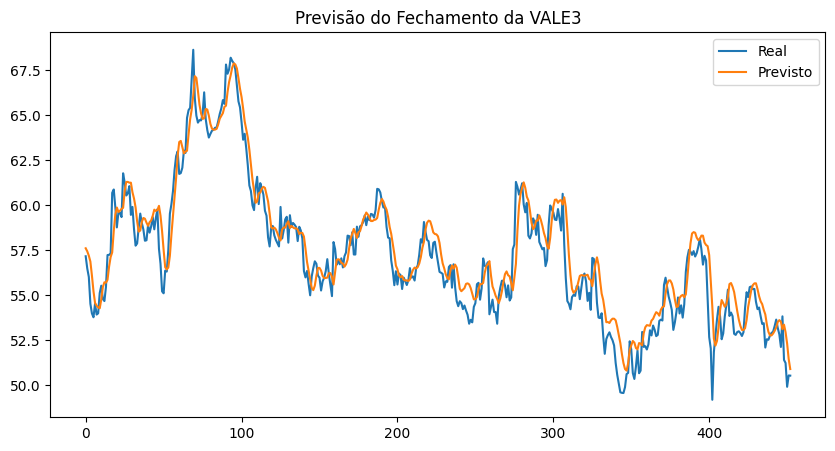

In [20]:
# Gráfico
plt.figure(figsize=(10,5))
plt.plot(y_real, label='Real')
plt.plot(pred_real, label='Previsto')
plt.legend()
plt.title('Previsão do Fechamento da VALE3')
plt.show()